In [33]:
import librosa
import numpy as np
import soundfile as sf
from scipy.signal import fftconvolve
from IPython.display import Audio

# Load original sweep (mono)
sweep, sr = librosa.load('Sine_sweep_single.wav', sr=None, mono=True)

# Load recorded response (stereo BRIR)
recorded, _ = librosa.load('Binaural_impulse.wav', sr=sr, mono=False)



In [55]:
# Assuming you have a logarithmic sweep
def create_inverse_sweep(sweep):
    # Time-reverse the sweep
    inverse = sweep[::-1]
    
    # Apply amplitude envelope correction for log sweeps
    t = np.arange(len(sweep))
    envelope = np.exp(-t / len(t) * np.log(sweep.shape[0]))
    
    # Apply the envelope to the time-reversed sweep
    inverse = inverse * envelope
    
    return inverse

In [57]:
inverse_sweep = create_inverse_sweep(sweep)

# Convolve each channel of the recorded response with the inverse sweep
ir_left = fftconvolve(recorded[0], inverse_sweep, mode='full')
ir_right = fftconvolve(recorded[1], inverse_sweep, mode='full')

# Stack as stereo BRIR
brir = np.vstack((ir_left, ir_right))


In [58]:
# Normalize to prevent clipping
brir /= np.max(np.abs(brir))

# Save result
sf.write('deconvolved_brir.wav', brir.T, sr)


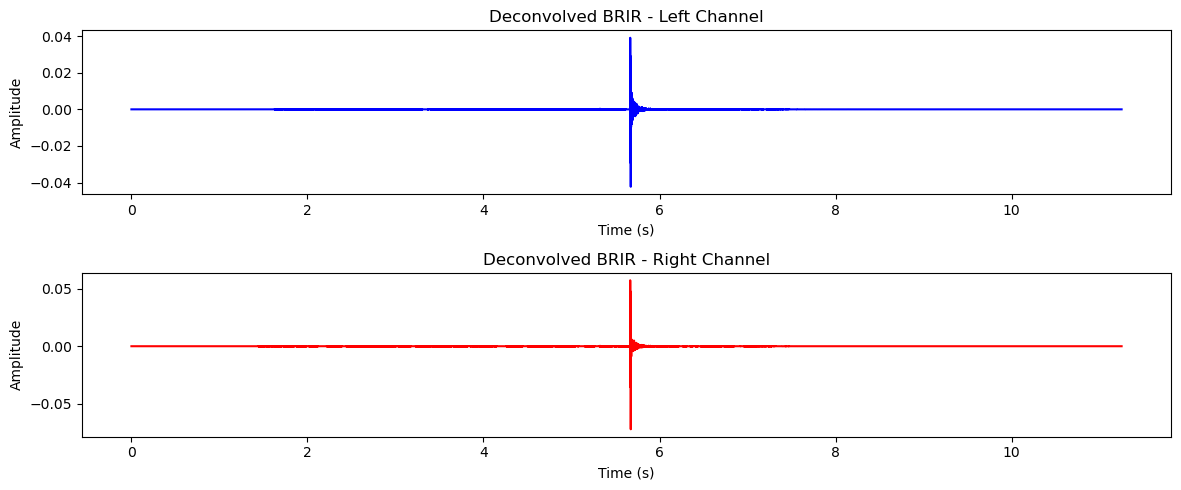

In [59]:
import matplotlib.pyplot as plt
import numpy as np

# Time axis (in seconds)
t = np.arange(len(ir_left)) / sr

# Plot
plt.figure(figsize=(12, 5))

plt.subplot(2, 1, 1)
plt.plot(t, ir_left, color='blue')
plt.title("Deconvolved BRIR - Left Channel")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")

plt.subplot(2, 1, 2)
plt.plot(t, ir_right, color='red')
plt.title("Deconvolved BRIR - Right Channel")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")

plt.tight_layout()
plt.show()


In [60]:
# Find the peak of the impulse response
peak_index_left = np.argmax(np.abs(ir_left))
peak_index_right = np.argmax(np.abs(ir_right))

# Trim to keep only the useful part keep 100 samples before peak and the rest after peak
pre_samples = 100
ir_left_trimmed = ir_left[peak_index_left-pre_samples:]
ir_right_trimmed = ir_right[peak_index_right-pre_samples:]

# Make sure both channels have the same length
min_length = min(len(ir_left_trimmed), len(ir_right_trimmed))
ir_left_trimmed = ir_left_trimmed[:min_length]
ir_right_trimmed = ir_right_trimmed[:min_length]

# Create the final trimmed BRIR
brir_trimmed = np.vstack((ir_left_trimmed, ir_right_trimmed))

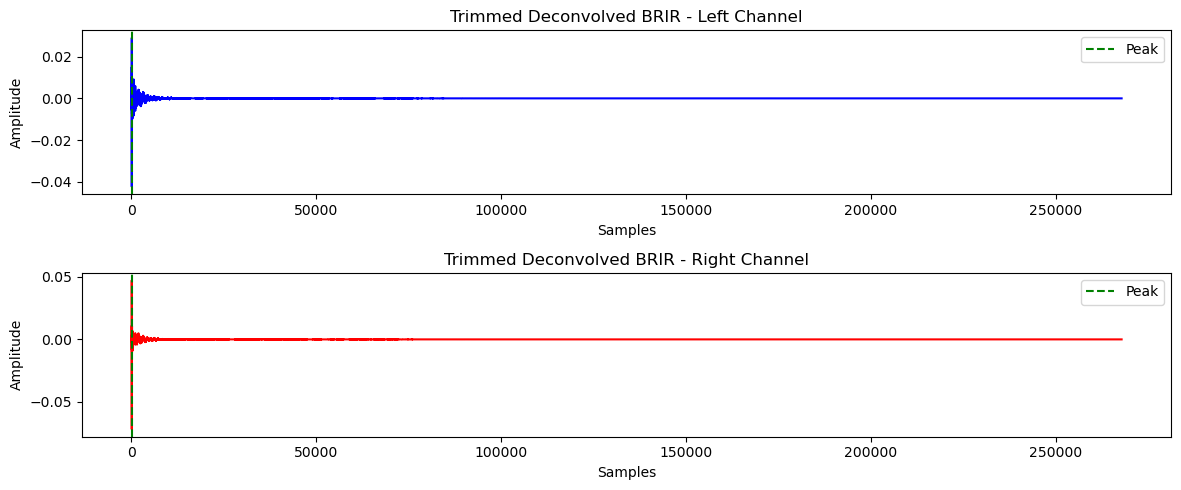

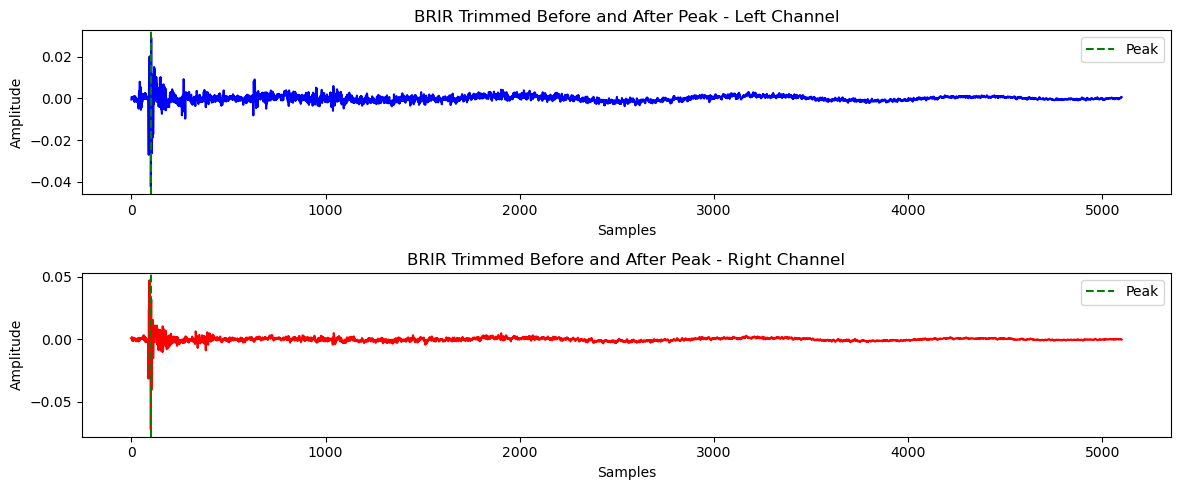

In [65]:
# Find the peak of the impulse response
peak_index_left = np.argmax(np.abs(ir_left))
peak_index_right = np.argmax(np.abs(ir_right))

# Trim to keep only the useful part keep 100 samples before peak
pre_samples = 100
ir_left_trimmed = ir_left[peak_index_left-pre_samples:]
ir_right_trimmed = ir_right[peak_index_right-pre_samples:]

# Make sure both channels have the same length
min_length = min(len(ir_left_trimmed), len(ir_right_trimmed))
ir_left_trimmed = ir_left_trimmed[:min_length]
ir_right_trimmed = ir_right_trimmed[:min_length]

# Create the final trimmed BRIR
brir_trimmed = np.vstack((ir_left_trimmed, ir_right_trimmed))

# Sample indices for x-axis
samples = np.arange(min_length)

# Plot the trimmed BRIR with samples on x-axis
plt.figure(figsize=(12, 5))

# Plot Left Channel (trimmed)
plt.subplot(2, 1, 1)
plt.plot(samples, ir_left_trimmed, color='blue')
plt.title("Trimmed Deconvolved BRIR - Left Channel")
plt.xlabel("Samples")
plt.ylabel("Amplitude")
# Add a vertical line at sample 100 (pre_samples) to mark the peak
plt.axvline(x=pre_samples, color='green', linestyle='--', label='Peak')
plt.legend()

# Plot Right Channel (trimmed)
plt.subplot(2, 1, 2)
plt.plot(samples, ir_right_trimmed, color='red')
plt.title("Trimmed Deconvolved BRIR - Right Channel")
plt.xlabel("Samples")
plt.ylabel("Amplitude")
# Add a vertical line at sample 100 (pre_samples) to mark the peak
plt.axvline(x=pre_samples, color='green', linestyle='--', label='Peak')
plt.legend()

plt.tight_layout()
plt.show()

# If you want to trim after the peak as well, you can do:
post_samples = 5000  # keep 5000 samples after the peak
ir_left_trimmed_both = ir_left[peak_index_left-pre_samples:peak_index_left+post_samples]
ir_right_trimmed_both = ir_right[peak_index_right-pre_samples:peak_index_right+post_samples]

# Make sure both channels have the same length
min_length_both = min(len(ir_left_trimmed_both), len(ir_right_trimmed_both))
ir_left_trimmed_both = ir_left_trimmed_both[:min_length_both]
ir_right_trimmed_both = ir_right_trimmed_both[:min_length_both]

# Create the final trimmed BRIR (trimmed both before and after peak)
brir_trimmed_both = np.vstack((ir_left_trimmed_both, ir_right_trimmed_both))

# Plot with samples on x-axis for the version trimmed on both sides
samples_both = np.arange(min_length_both)

plt.figure(figsize=(12, 5))
plt.subplot(2, 1, 1)
plt.plot(samples_both, ir_left_trimmed_both, color='blue')
plt.title("BRIR Trimmed Before and After Peak - Left Channel")
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.axvline(x=pre_samples, color='green', linestyle='--', label='Peak')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(samples_both, ir_right_trimmed_both, color='red')
plt.title("BRIR Trimmed Before and After Peak - Right Channel")
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.axvline(x=pre_samples, color='green', linestyle='--', label='Peak')
plt.legend()

plt.tight_layout()
plt.show()

In [62]:
# Load mono dry input audio
audio, sr = librosa.load('majula.wav', sr=None, mono=True)

# Load the BRIR audio file
brir, brir_sr = librosa.load('Trimmed_BRIR.wav', sr=None, mono=False)

# Make sure it's stereo
if brir.ndim != 2 or brir.shape[0] != 2:
    raise ValueError("BRIR must be stereo with shape (2, N)")

# Convolve input audio with BRIR
wet_left = fftconvolve(audio, brir[0], mode='full')
wet_right = fftconvolve(audio, brir[1], mode='full')

# Combine and normalize
wet = np.vstack((wet_left, wet_right))
wet /= np.max(np.abs(wet))

# Save to file (optional)
sf.write('convolved_majula.wav', wet.T, sr)

In [63]:

Audio('convolved_majula.wav', rate=sr)

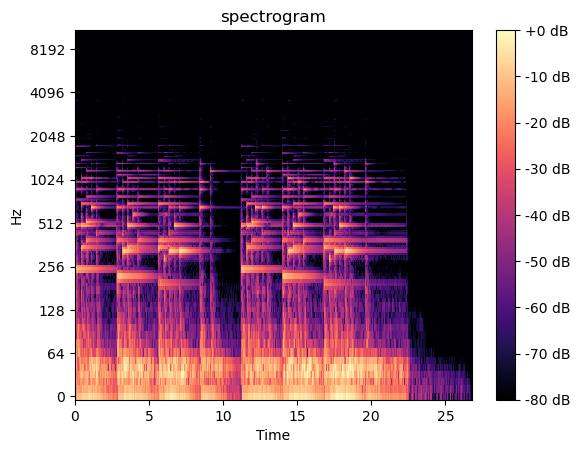

In [64]:
y, sr = librosa.load('convolved_majula.wav')

#compute the STFT
S = np.abs(librosa.stft(y))
fig, ax = plt.subplots()
img = librosa.display.specshow(librosa.amplitude_to_db(S,
                                                       ref=np.max),
                               y_axis='log', x_axis='time', ax=ax)
ax.set_title('spectrogram')
fig.colorbar(img, ax=ax, format="%+2.0f dB")